Now you can run the previous cell to import `torch` and `make_dot`.

Base MedVit Code

In [5]:
import tensorflow as tf
## reduce GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/Colab\ Notebooks/Med-ViT-3D-main

/content/drive/MyDrive/Colab Notebooks/Med-ViT-3D-main


In [ ]:
!pip install medmnist==3.0.1 \
    torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
  

In [6]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchsummary import summary

from tqdm import tqdm
import medmnist
from medmnist import INFO, Evaluator

import torchattacks
from torchattacks import PGD, FGSM

In [7]:
print("PyTorch", torch.__version__)
print("Torchvision", torchvision.__version__)
print("Torchattacks", torchattacks.__version__)
print("Numpy", np.__version__)
print("Medmnist", medmnist.__version__)

PyTorch 2.6.0+cu124
Torchvision 0.21.0+cu124
Torchattacks 3.5.1
Numpy 1.26.4
Medmnist 3.0.1


##Dataset

## Model loader

In [8]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

## Train

### Team7: Continue training by loading history

In [9]:
from sklearn.metrics import roc_auc_score, accuracy_score
import pandas as pd

# evaluation
def getAUC(y_true, y_score, task):
    """AUC metric.
    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1
    :param y_score: the predicted score of each class,
    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1
    :param task: the task of current dataset
    """
    y_true = y_true.squeeze()
    y_score = y_score.squeeze()

    if task == "multi-label, binary-class":
        auc = 0
        for i in range(y_score.shape[1]):
            label_auc = roc_auc_score(y_true[:, i], y_score[:, i])
            auc += label_auc
        ret = auc / y_score.shape[1]
    elif task == "binary-class":
        if y_score.ndim == 2:
            y_score = y_score[:, -1]
        else:
            assert y_score.ndim == 1
        ret = roc_auc_score(y_true, y_score)
    else:
        auc = 0
        for i in range(y_score.shape[1]):
            y_true_binary = (y_true == i).astype(float)
            y_score_binary = y_score[:, i]
            auc += roc_auc_score(y_true_binary, y_score_binary)
        ret = auc / y_score.shape[1]

    return ret


def getACC(y_true, y_score, task, threshold=0.5):
    """Accuracy metric.
    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1
    :param y_score: the predicted score of each class,
    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1
    :param task: the task of current dataset
    :param threshold: the threshold for multilabel and binary-class tasks
    """
    y_true = y_true.squeeze()
    y_score = y_score.squeeze()

    if task == "multi-label, binary-class":
        y_pre = y_score > threshold
        acc = 0
        for label in range(y_true.shape[1]):
            label_acc = accuracy_score(y_true[:, label], y_pre[:, label])
            acc += label_acc
        ret = acc / y_true.shape[1]
    elif task == "binary-class":
        if y_score.ndim == 2:
            y_score = y_score[:, -1]
        else:
            assert y_score.ndim == 1
        ret = accuracy_score(y_true, y_score > threshold)
    else:
        ret = accuracy_score(y_true, np.argmax(y_score, axis=-1))

    return ret

def test(data_loader, model, criterion, task):
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)
    data_loader = data_loader
    total_loss = 0.0
    num_batches = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                loss = criterion(outputs, targets)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)
            total_loss += loss.item()
            num_batches += 1

        y_true = y_true.cpu().numpy()
        y_score = y_score.detach().cpu().numpy()

        auc = getAUC(y_true, y_score, task)
        acc = getACC(y_true, y_score, task)
        avg_loss = total_loss / num_batches

        return auc, acc ,avg_loss #, y_true, y_score


def load_or_initialize_model(model_class, model_name, optimizer_class, lr, momentum, n_classes, task):
    model_dir = "./history_record"
    os.makedirs(model_dir, exist_ok=True)

    model_path = os.path.join(model_dir, f"{model_name}.pth")
    history_path = os.path.join(model_dir, f"{model_name}.csv")


    model = MedViT_small(num_classes = n_classes).to(device)

    optimizer = optimizer_class(model.parameters(), lr=lr, momentum=momentum)

    start_epoch = 0
    best_val_auc = 0
    history = {
        "train_auc": [], "train_acc": [],
        "val_auc": [], "val_acc": [],
        "train_loss": [], "val_loss": []
    }

    if os.path.exists(model_path) and os.path.exists(history_path):
        print(f"Loading existing model: {model_name}")
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        history = pd.read_csv(history_path).to_dict(orient='list')
        start_epoch = len(history["train_loss"])
        best_val_auc = max(history["val_auc"]) if history["val_auc"] else 0

    return model, optimizer, history, start_epoch, best_val_auc
def training_and_record(model_class,
                        model_name,
                        NUM_EPOCHS, lr,
                        momentum, train_loader,
                        train_loader_at_eval,
                        test_loader,
                        n_classes,
                        task,
                        steps):
    model, optimizer, history, start_epoch, best_val_auc = load_or_initialize_model(
        model_class, model_name, optimizer_class=torch.optim.SGD, lr=lr, momentum=momentum, n_classes = n_classes,
        task = task
    )
    if task == "multi-label, binary-class":
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()
    total_loss = 0
    step_count = 0  # counter for batch steps
    for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
        print(f'\nEpoch [{epoch + 1}/{start_epoch + NUM_EPOCHS}]')
        model.train()

        for inputs, targets in tqdm(train_loader):
            step_count += 1
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            unique_classes = np.unique(targets.cpu().numpy())
            # print(f"Unique class in target data batch is: {unique_classes.tolist()}  | Count: {len(unique_classes)}")
            if task == 'multi-label, binary-class':
                # print("Going to multi-label, bunary-class branch")
                # Ensure targets become [B, n_classes] float
                targets = torch.nn.functional.one_hot(
                    targets.squeeze().long(), num_classes=n_classes
                ).float().to(device)
                # print("target shape of original data before loss ", targets.shape)
                # print("output shape after model, before loss: ", outputs.shape)
                loss = criterion(outputs, targets)
            else:
                # print("going to ther branch")
                targets = targets.squeeze().long()  # labels become long
                # print("target shape of original data before loss ", targets.shape)
                # print("output shape after model, before loss: ", outputs.shape)
                loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # stop after 20 steps per epoch
            # if step_count >= steps:
            #     print(f"Breaking after {step_count} steps in this epoch.")
            #     break

        torch.cuda.empty_cache()

        # Logging
        train_loss = total_loss / len(train_loader)
        # validation loss
        val_auc, val_acc, val_loss = test(test_loader, model, criterion, task)
        # train loss
        train_auc, train_acc, train_loss = test( train_loader_at_eval, model, criterion, task)


        history["train_auc"].append(train_auc)
        history["train_acc"].append(train_acc)
        history["train_loss"].append(train_loss)
        history["val_auc"].append(val_auc)
        history["val_acc"].append(val_acc)
        history["val_loss"].append(val_loss)


        # Save best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            print("📌 New best AUC — saving model")
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, f"./history_record/{model_name}.pth")

        pd.DataFrame(history).to_csv(f"./history_record/{model_name}.csv", index=False)

    print("✅ Training complete.")
    return history



## Team7: Fit into MedMNIST-3D

**MedVit3D**



In [10]:
data_flag = 'organmnist3d'
# [tissuemnist, pathmnist, chestmnist, dermamnist, octmnist,
# pnemoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist]
download = True

NUM_EPOCHS = 10
BATCH_SIZE = 15
lr = 0.005

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

print("number of channels : ", n_channels)
print("number of classes : ", n_classes)

number of channels :  1
number of classes :  11


In [11]:
from torchvision.transforms.transforms import Resize
# preprocessing
transform = lambda x: torch.from_numpy(x).squeeze(1).float()
train_dataset = DataClass(split='train', transform=transform, download=True)
val_dataset = DataClass(split='val', transform=transform, download=True)
test_dataset = DataClass(split='test', transform=transform, download=True)


# pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


In [12]:
len(train_loader)


65

In [13]:
n_classes

11

In [15]:
from MedVit3D import MedViT3D_small
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MedViT3D_small(num_classes = n_classes).to(device)

/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [16]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
model.train()
for inputs, targets in train_loader:
    inputs = inputs.to(device)
    targets = targets.squeeze()  # Remove extra dimension
    if targets.ndim != 1:
        targets = targets.view(-1)  # Ensure shape is [B]
    targets = targets.long().to(device)

    optimizer.zero_grad()
    outputs = model(inputs)  # Shape: [B, num_classes]
    loss = criterion(outputs, targets)  # targets: [B]
    loss.backward()
    optimizer.step()

    print("Loss:", loss.item())
    break  # Only run 1 batch for testing


Loss: 2.4444475173950195


In [17]:
model.eval()
all_preds = []
all_labels = []
from sklearn.metrics import accuracy_score

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.squeeze()
        if targets.ndim != 1:
            targets = targets.view(-1)
        targets = targets.long().to(device)

        outputs = model(inputs)  # logits
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

# ✅ Calculate Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.1131


In [18]:
## train full batch
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.squeeze().long().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            all_outputs.append(outputs.softmax(dim=1).cpu().numpy())
            all_labels.append(targets.cpu().numpy())

    # Flatten
    all_preds = np.concatenate(all_outputs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Metrics
    acc = accuracy_score(all_labels, all_preds.argmax(axis=1))
    try:
        auc = roc_auc_score(all_labels, all_preds, multi_class='ovr')
    except:
        auc = -1  # fallback if AUC fails (e.g., single class present)

    avg_loss = total_loss / len(loader)
    return avg_loss, acc, auc
model.train()
total_loss = 0

for inputs, targets in train_loader:
    inputs = inputs.to(device)
    targets = targets.squeeze().long().to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

train_loss = total_loss / len(train_loader)
val_loss, val_acc, val_auc = evaluate(model, test_loader, device)
_, train_acc, train_auc = evaluate(model, train_loader, device)

print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train AUC: {train_auc:.4f}")
print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f} | Val AUC:   {val_auc:.4f}")


Train Loss: 2.1613 | Train Acc: 0.4130 | Train AUC: 0.9146
Val Loss:   1.9240 | Val Acc:   0.3869 | Val AUC:   0.8956


In [ ]:
## train multiple epoch

In [19]:
def load_or_initialize_model(model_class, model_name, optimizer_class, lr, momentum, n_classes):
    model_dir = "./history_record"
    os.makedirs(model_dir, exist_ok=True)

    model_path = os.path.join(model_dir, f"{model_name}.pth")
    history_path = os.path.join(model_dir, f"{model_name}.csv")

    model = MedViT3D_small(num_classes = n_classes).to(device)
    optimizer = optimizer_class(model.parameters(), lr=lr, momentum=momentum)
    start_epoch = 0
    best_val_auc = 0
    history = {
        "train_auc": [], "train_acc": [],
        "val_auc": [], "val_acc": [],
        "train_loss": []
    }

    if os.path.exists(model_path) and os.path.exists(history_path):
        print(f"Loading existing model: {model_name}")
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        history = pd.read_csv(history_path).to_dict(orient='list')
        start_epoch = len(history["train_loss"])
        best_val_auc = max(history["val_auc"]) if history["val_auc"] else 0

    return model, optimizer, history, start_epoch, best_val_auc

In [27]:
criterion = nn.CrossEntropyLoss()
def training_and_record(model_class, model_name, NUM_EPOCHS, lr, momentum, train_loader, train_loader_at_eval, test_loader, n_classes):
    model, optimizer, history, start_epoch, best_val_auc = load_or_initialize_model(
        model_class, model_name, optimizer_class=torch.optim.SGD, lr=lr, momentum=momentum, n_classes= n_classes
    )

    for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
        print(f'\nEpoch [{epoch + 1}/{start_epoch + NUM_EPOCHS}]')
        model.train()
        total_loss = 0
        for inputs, targets in tqdm(train_loader):
            inputs = inputs.to(device)
            targets = targets.squeeze().long().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            # print("Unique labels:", targets.unique())
            # print("Targets shape:", targets.shape)
            # print("Output shape:", outputs.shape)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        torch.cuda.empty_cache()

        # Logging
        train_loss = total_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate(model, test_loader, device)
        _, train_acc, train_auc = evaluate(model, train_loader, device)

        history["train_auc"].append(train_auc)
        history["train_acc"].append(train_acc)
        history["val_auc"].append(val_auc)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(train_loss)

        # Save best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            print("📌 New best AUC — saving model")
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, f"./history_record/{model_name}.pth")

        pd.DataFrame(history).to_csv(f"./history_record/{model_name}.csv", index=False)

    print("✅ Training complete.")
    return history, model


In [20]:
lr

0.005

In [28]:
## Train môre epoch and recording.
import os
import pandas as pd
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
history, model = training_and_record(
    model_class=MedViT3D_small,
    model_name="MedViT3D_organmnist3d",
    NUM_EPOCHS=NUM_EPOCHS,
    lr=lr,
    momentum=0.9,
    train_loader=train_loader,
    train_loader_at_eval=train_loader_at_eval,
    test_loader=test_loader,
    n_classes = n_classes
)

Loading existing model: MedViT3D_organmnist3d

Epoch [11/20]


100%|██████████| 65/65 [00:02<00:00, 24.01it/s]



Epoch [12/20]


100%|██████████| 65/65 [00:02<00:00, 30.95it/s]


📌 New best AUC — saving model

Epoch [13/20]


100%|██████████| 65/65 [00:02<00:00, 30.27it/s]


📌 New best AUC — saving model

Epoch [14/20]


100%|██████████| 65/65 [00:02<00:00, 30.56it/s]



Epoch [15/20]


100%|██████████| 65/65 [00:02<00:00, 30.55it/s]



Epoch [16/20]


100%|██████████| 65/65 [00:02<00:00, 30.31it/s]



Epoch [17/20]


100%|██████████| 65/65 [00:02<00:00, 29.49it/s]



Epoch [18/20]


100%|██████████| 65/65 [00:02<00:00, 29.97it/s]



Epoch [19/20]


100%|██████████| 65/65 [00:02<00:00, 29.88it/s]



Epoch [20/20]


100%|██████████| 65/65 [00:02<00:00, 27.69it/s]


✅ Training complete.


In [ ]:
## Grad CAM for model explanation

In [32]:
!pip install torchcam
# OR
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 103.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires requests>=2.32.2, but you have requests 2.25.1 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
yfinance 0.2.65 requires requests>=2.31, but you have requests 2.25.1 which is i

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.8 MB/s eta 0:00:00
^C


In [22]:
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

cam_extractor = GradCAM(model, target_layer="ltb1")

In [29]:
model.eval()

# Select a sample from test loader
inputs, targets = next(iter(test_loader))
inputs = inputs.to(device)
targets = targets.squeeze().long().to(device)

# Forward pass and CAM extraction
with torch.no_grad():
    output = model(inputs)
    pred_class = output.argmax(dim=1)

# Extract CAM for the first image
cam = cam_extractor(pred_class[0].item(), output)  # Automatically registers and removes hooks

# Process image and heatmap
input_image = inputs[0].cpu().squeeze().numpy()  # [D, H, W]
slice_idx = input_image.shape[0] // 2
slice_img = input_image[slice_idx]
slice_cam = cam[0][slice_idx]

# Normalize and overlay
from torchvision.transforms.functional import to_pil_image
from torchcam.utils import overlay_mask
import matplotlib.pyplot as plt

norm_slice = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min())
norm_cam = (slice_cam - slice_cam.min()) / (slice_cam.max() - slice_cam.min())

overlay = overlay_mask(to_pil_image(norm_slice), to_pil_image(norm_cam), alpha=0.6)

plt.imshow(overlay)
plt.title(f"Grad-CAM (Pred: {pred_class[0].item()}, True: {targets[0].item()})")
plt.axis('off')
plt.show()


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

NameError: name 'target_class' is not defined

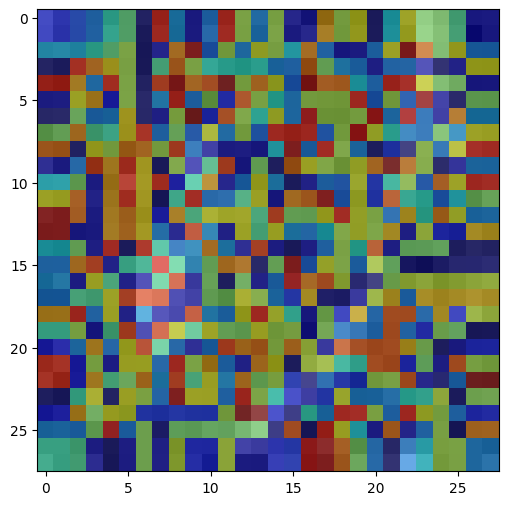

In [24]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

# === Setup ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval().to(device)

# === Choose target layer for GradCAM ===
target_layer = 'ltb3.conv.0'  # Change if needed
cam_extractor = GradCAM(model, target_layer=target_layer)

# === Load 1 test sample ===
inputs, targets = next(iter(test_loader))
input_tensor = inputs[0].unsqueeze(0).to(device)  # [1, 1, D, H, W]
true_label = targets[0].item()

# === Forward pass & CAM extraction ===
with torch.set_grad_enabled(True):
    scores = model(input_tensor)
    pred_class = scores.argmax(dim=1).item()
    cams = cam_extractor(pred_class, scores)  # list of CAMs

# === Get the CAM tensor ===
cam = cams[0]  # Could be [1, D, H, W] or [D, H, W]
if cam.dim() == 3:
    cam = cam.unsqueeze(0).unsqueeze(0)  # → [1, 1, D, H, W]
elif cam.dim() == 4:
    cam = cam.unsqueeze(0)               # → [1, 1, D, H, W]
# Else: already fine

# === Interpolate CAM to input shape ===
target_shape = input_tensor.shape[2:]  # [D, H, W]
cam_upsampled = F.interpolate(cam, size=target_shape, mode="trilinear", align_corners=False)

cam_volume = cam_upsampled.squeeze().cpu()  # [D, H, W]

# === Get input volume ===
input_volume = input_tensor.squeeze().cpu()  # [D, H, W]

# === Pick a middle slice ===
slice_idx = input_volume.shape[0] // 2
input_slice = input_volume[slice_idx]  # [H, W]
cam_slice = cam_volume[slice_idx]      # [H, W]

# === Normalize both slices ===
input_norm = (input_slice - input_slice.min()) / (input_slice.max() - input_slice.min() + 1e-6)
cam_norm = (cam_slice - cam_slice.min()) / (cam_slice.max() - cam_slice.min() + 1e-6)

# === Convert to PIL images ===
input_pil = to_pil_image(input_slice)
cam_pil = to_pil_image(cam_slice)

# Convert grayscale input to RGB for overlay
input_pil = input_pil.convert("RGB")

# === Overlay CAM ===
overlay = overlay_mask(input_pil, cam_pil, alpha=0.5)

# === Plot ===
plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title(f"Grad-CAM Overlay (slice {slice_idx}) | Pred: {pred_class} | GT: {target_class}")
plt.axis("off")
plt.show()


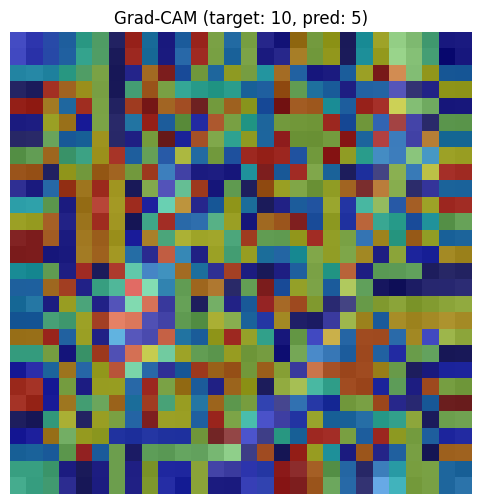

In [25]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

# === Prepare your model ===
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Choose a target layer name from your model — ltb3 is good
target_layer = "ltb3"

# Initialize GradCAM
cam_extractor = GradCAM(model, target_layer=target_layer)

# === Pick one test sample ===
inputs, targets = next(iter(test_loader))
inputs = inputs.to(device)
input_tensor = inputs[0].unsqueeze(0)  # [1, C, D, H, W]
target_class = targets[0].item()

# === Forward pass and CAM generation ===
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

# Generate CAM
cams = cam_extractor(pred_class, output)
cam = cams[0]

if cam.dim() == 3:
    cam = cam.unsqueeze(0).unsqueeze(0)  # → [1, 1, D, H, W]
elif cam.dim() == 4:
    cam = cam.unsqueeze(0)               # → [1, 1, D, H, W]
# === Interpolate CAM to match input size ===
target_shape = input_tensor.shape[2:]  # [D, H, W]
cam_upsampled = F.interpolate(cam, size=target_shape, mode="trilinear", align_corners=False)

cam_volume = cam_upsampled.squeeze().cpu()  # [D, H, W]


# === Normalize input volume ===
input_volume = input_tensor.squeeze().cpu()  # [D, H, W]
input_volume = (input_volume - input_volume.min()) / (input_volume.max() - input_volume.min())

# === Choose center slice ===
slice_idx = input_volume.shape[0] // 2
input_slice = input_volume[slice_idx]  # [H, W]
cam_slice = cam_volume[slice_idx]      # [H, W]

# Normalize CAM slice
cam_slice = (cam_slice - cam_slice.min()) / (cam_slice.max() - cam_slice.min())

# Convert grayscale input to RGB for overlay
input_pil = input_pil.convert("RGB")

# === Overlay CAM ===
overlay = overlay_mask(input_pil, cam_pil, alpha=0.5)

# === Plot result ===
plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title(f"Grad-CAM (target: {target_class}, pred: {pred_class})")
plt.axis('off')
plt.show()
